# Rainforest Connection Species Audio Detection (画像処理、学習編)

本ノートブックは、主にPythonや機械学習を初めて音声分類について学びたい方むけに、[「Rainforest Connection Species Audio Detection」](https://www.kaggle.com/c/rfcx-species-audio-detection)を題材にスクリプトを作成しました。チュートリアル形式なのでぜひ皆様に手を動かしてもらい、一緒に学んでいきましょう！

本チュートリアルでは、採用した方針やそれぞれの手法の論理については説明を省きますが、詳しく知りたい方は、ぜひ、[【実装】機械学習で森の生き物を守る？](https://)を読んでみてください。

In [18]:
import os
from google.colab import files, drive
drive.mount('/content/drive')
DRIVE_PATH = '/content/drive/MyDrive/RCSAD'
os.chdir(f'{DRIVE_PATH}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install transformers efficientnet_pytorch &> /dev/null

In [20]:
!pip install git+https://github.com/zhanghang1989/ResNeSt

  Cloning https://github.com/zhanghang1989/ResNeSt to /tmp/pip-req-build-tocip3np
  Running command git clone -q https://github.com/zhanghang1989/ResNeSt /tmp/pip-req-build-tocip3np


In [21]:
# インポート
import random
import math
import time
import datetime
import h5py
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup

from efficientnet_pytorch import EfficientNet

In [22]:
# 設定値
npy_files = 'npy_files'
num_classes = 24
one_hot = np.eye(num_classes)
cut = 6
sample_time = 5
image_height, image_width = 300, 300
num_cpu = multiprocessing.cpu_count()
audio_length = 60

## カスタムデータローダー

In [23]:
def load_dataset(label, h5file):
    dataset = h5py.File(f'{h5file}.hdf5', 'r')
    recording_ids = [i.decode('utf-8') for i in dataset[f'{label}_labels']]
    data = {k:v for k, v in tqdm(zip(recording_ids, dataset[f'{label}_files']), total=len(recording_ids))}
    return data

train_data = load_dataset('train', npy_files)
test_data = load_dataset('test', npy_files)

df_tp = pd.read_csv(f'train_tp.csv')
df_test = pd.read_csv(f'sample_submission.csv')

100%|██████████| 3984/3984 [00:18<00:00, 218.29it/s]


In [24]:
def cut_train(x):
    full = x['audio_spec'].shape[1] 
    adj = full / audio_length

    center = (x['t_max'] + x['t_min']) / 2

    tmax = center + cut / 2
    tmin = center - cut / 2

    extra_min = max(0, tmax - audio_length)
    extra_max = -min(0, tmin)
    start_cut = max(0, tmin) - extra_min
    end_cut = min(audio_length, tmax) + extra_max
    half_time = (cut - sample_time) / 2
    extra = np.random.uniform(-half_time, half_time)

    start_cut += extra + half_time
    end_cut += extra - half_time

    start_cut = int(start_cut * adj)
    end_cut = int(end_cut * adj)

    x['audio_spec'] = x['audio_spec'][:, start_cut: end_cut]
    return x
    
def test_df(dfx):
    def summary_row(row):
        stride = 1
        cuts = np.vstack([[i,i+sample_time] for i in range(0, audio_length-stride, stride)])
        row_new = pd.DataFrame(data={'recording_id': row.iloc[0, 0],
                        't_min': cuts[:, 0],
                        't_max': cuts[:, 1]
                        })
        return row_new

    df_new = dfx.groupby(['recording_id'], as_index=False).apply(summary_row).reset_index(drop=True)
    return df_new
    
def cut_test(x):
    full = x['audio_spec'].shape[1]
    adj = full / audio_length

    tmax = x['t_max']
    tmin = x['t_min']

    half_length = sample_time / 2
    center = (tmax + tmin) / 2
    
    extra_min = max(0, center + half_length - audio_length)
    extra_max = -min(0, center - half_length)
    
    start_cut = max(0, center - half_length) - extra_min
    end_cut = min(audio_length, center + half_length) + extra_max

    start_cut = int(start_cut * adj)
    end_cut = int(end_cut * adj)

    x['audio_spec'] = x['audio_spec'][:, start_cut:end_cut]
    return x

class AudioDataset(Dataset):
    def __init__(self, df, transform=None, data=train_data, train=True):
        self.train = train
        self.data = data
        self.files = df['recording_id'].values
        self.df = df
        self.transform = transform
        self.y = [one_hot[int(i)] for i in df['species_id'].values]

    def __len__(self):
        return len(self.files) 

    def __getitem__(self, idx: int):
        new_files = np.array(['0' + self.files[i] for i in range(len(self.files))] +
                             ['1' + self.files[i] for i in range(len(self.files))]
                             ).astype('object')
        recording_id = new_files[idx]
        data = self.df.iloc[idx, :]
        X = self.data[recording_id]
        species_id = data['species_id']

        output = {
            'audio_spec': X,
            'recording_id': recording_id,
            'species_id': species_id,
            't_min': data['t_min'],
            't_max': data['t_max'],
            'target': self.y[idx],
        }

        if self.train:
            output = cut_train(output)
        else:
            output = cut_test(output)

        if self.transform is not None:
            image = self.transform(output['audio_spec'])
            image = image.numpy()
            output['audio_spec'] = image

        return output
        
class TestDataset(Dataset):
    def __init__(self, df, transform=None, data=test_data):
        self.data = data
        self.files = df['recording_id'].values
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.files) 

    def __getitem__(self, idx: int):
        new_files = np.array(['0' + self.files[i] for i in range(len(self.files))] +
                             ['1' + self.files[i] for i in range(len(self.files))]
                             ).astype('object')
        recording_id = new_files[idx]
        X = self.data[recording_id]
        data = self.df.iloc[idx, :]

        output = {
            'audio_spec': X,
            't_min': data['t_min'],
            't_max': data['t_max']
        }

        output = cut_test(output)

        if self.transform is not None:
            image = self.transform(output['audio_spec'])
            image = image.numpy()

        return {
            'audio_spec': image,
            'recording_id': recording_id
        }
train_dataset = AudioDataset(df=df_tp)

## 画像前処理

In [25]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=0.2, sigma=0.3, prob=0.8):
        self.std = std
        self.mean = mean
        self.sigma = sigma
        self.prob = prob
        
    def __call__(self, tensor):
        if torch.rand(1) < self.prob:
            sample_noise = torch.randn(tensor.shape) * self.std + self.mean
            sample_noise *= self.sigma
            tensor = tensor + sample_noise.to('cpu').detach().numpy().copy()
        return np.uint8(tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class FlipImage(object):
  def __init__(self, rateV=0.33, rateH=0.33):
      self.rateV = rateV
      self.rateH = rateH
  def __call__(self, tensor):
    if np.random.rand() < self.rateV:
        tensor = tensor[::-1]
    return tensor
  def __repr__(self):
        return self.__class__.__name__

class MonoToColor(object):
    def __init__(self, eps=1e-6, mean=None, std=None):
        self.mean = mean
        self.std = std
        self.eps = eps

    def __call__(self, X):
        # Standardize
        mean = self.mean or X.mean()
        std = self.std or X.std()
        X = (X - mean) / (std + self.eps)

        # Normalize to [0, 255]
        _min, _max = X.min(), X.max()

        if (_max - _min) > self.eps:
            V = np.clip(X, _min, _max)
            V = 255 * (V - _min) / (_max - _min)
            V = V.astype(np.uint8)
        else:
            V = np.zeros_like(X, dtype=np.uint8)

        V = np.stack([V, V, V], axis=-1)
        V = V.astype(np.uint8)
        return V
    
    def __repr__(self):
        return self.__class__.__name__    

## モデリング

In [26]:
def obtain_model(name, num_classes=24):
    # resnest_
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=False)
        model.load_state_dict(torch.load('resnest50_fast.pth'))
    elif "efficientnet" in name:
        model = EfficientNet.from_pretrained(name)
    else:
        raise NotImplementedError

    if "efficientnet" not in name and "se" not in name:
        nb_ft = model.fc.in_features
        del model.fc
        model.fc = nn.BatchNorm1d(nb_ft)
    else:
        nb_ft = model._fc.in_features
        del model._fc
        model._fc = nn.BatchNorm1d(nb_ft)

    layers = 64
    dropout = 0.3
    modules = [
                model,
                nn.Dropout(dropout),
                nn.Linear(nb_ft, layers),
                nn.ReLU(),
                nn.BatchNorm1d(layers),
                nn.Dropout(dropout),
                nn.Linear(layers, num_classes)
               ]

    return nn.Sequential(*modules)

## 学習&精度評価準備

In [27]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], truth[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    return per_class_lwlrap, weight_per_class
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class MetricMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
    
    def update(self, y_true, y_pred):
        self.y_true.extend(y_true.cpu().detach().numpy().tolist())
        self.y_pred.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

    @property
    def avg(self):
        score_class, weight = lwlrap(np.array(self.y_true), np.array(self.y_pred))
        self.score = (score_class * weight).sum()

        return {"lwlrap" : self.score}

class Score(object):
    def __init__(self, target='max'):
        self.target = target
        self.target_func = max if target == 'max' else min
        self.reset()

    def reset(self):
        self.values = []
        self.best_index = None
        self.best = float('inf') if self.target == 'min' else -float('inf')

    def update(self, value):
        self.values.append(value)
        self.best = self.target_func(self.best, value)
        if self.best == value:
            self.best_index = len(self.values) - 1
    
    @property
    def improved(self):
        return self.best_index == len(self.values) - 1

class ScoreLoss(object):
    def __init__(self, score_target='max', loss_target='min'):
        self.score_target = 'max'
        self.loss_target = 'min'
        self.reset()

    def reset(self):
        self.score = Score(target=self.score_target)
        self.loss = Score(target=self.loss_target)
    
    def update(self, loss, score):
        self.score.update(score)
        self.loss.update(loss)
    
    @property
    def score_improved(self):
        return self.score.improved

    @property
    def loss_improved(self):
        return self.loss.improved
class History(object):
    def __init__(self, score_target='max', loss_target='min'):
        self.score_target = 'max'
        self.loss_target = 'min'
        self.reset()
    
    def reset(self):
        self.val = ScoreLoss(score_target=self.score_target, loss_target=self.loss_target)
        self.train = ScoreLoss(score_target=self.score_target, loss_target=self.loss_target)
        self.pred = None
        self.model_weights = None
    
    def update(self, loss, score, val_loss, val_score):
        self.val.update(val_loss, val_score)
        self.train.update(loss, score)

    def update_pred(self, pred, model):
        if self.score_improved:
            self.pred = pred
            self.model_weights = model.state_dict()
    
    @property
    def history(self):
        return {
            'loss': self.train.loss.values,
            'score': self.train.score.values,
            'val_loss': self.val.loss.values,
            'val_score': self.val.score.values
        }

    @property
    def best_result(self):
        return {
            'score': self.val.score.best,
            'loss': self.val.loss.values[self.val.score.best_index]
        }
    
    @property
    def score_improved(self):
        return self.val.score_improved

    @property
    def loss_improved(self):
        return self.val.loss_improved

In [28]:
def plot_history(history, filename):
    validation = history.history["val_loss"]
    score = history.history["val_score"]
    best_score = max(score)
    index_score = score.index(best_score)
    print(f'epoch: {index_score + 1}, loss: {validation[index_score]:.4f}, score: {best_score:.4}')

    plt.style.use('dark_background')
    plt.rcParams.update({'font.size': 15, 'axes.xmargin': 0})

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    ax1.plot(history.history['score'])
    ax1.plot(history.history['val_score'])
    ax1.set_title('score')
    ax1.set_ylabel('score')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper right')
    plt.show()
    try:
        plt.savefig(filename)
    except:
        print('Failed image save')
        pass

In [29]:
def load_model_weights(model, filename, verbose=1, cp_folder=""):
    if verbose:
        print(f"\n -> Loading weights from {os.path.join(cp_folder,filename)}\n")
    try:
        model.load_state_dict(os.path.join(cp_folder, filename), strict=strict)
    except BaseException:
        model.load_state_dict(
            torch.load(os.path.join(cp_folder, filename), map_location="cpu"),
            strict=True,
        )
    return model


def save_model_weights(model, filename, verbose=1, cp_folder=""):
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

In [30]:
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

    index = torch.randperm(x.size()[0]).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def fit(
    model,
    train_dataset,
    val_dataset,
    epochs=30,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    alpha=0.4,
    mixup_proba=0.0,
    accum_gradient=None
):
    losses = AverageMeter()
    scores = MetricMeter()
    history = History()

    optimizer = Adam(model.parameters(), lr=lr) #オプティマイザー
    loss_fct = nn.BCEWithLogitsLoss(reduction="mean").cuda() # 損失関数

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=num_cpu,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        pin_memory=True, 
        num_workers=num_cpu
    )
    
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    ) # スケジューラー

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        optimizer.zero_grad()
        avg_loss = 0
        scores.reset()
        losses.reset()

        for step, sample in enumerate(train_loader):
            X, y = sample['audio_spec'], sample['target']


            if np.random.rand() < mixup_proba:
                X, y_a, y_b, _ = mixup_data(X.cuda(), y.cuda(), alpha=alpha)
                y = torch.clamp(y_a + y_b, 0, 1)

            y_pred = model(X.cuda())
            loss = loss_fct(y_pred, y.cuda().float())

            scores.update(y, y_pred)
            losses.update(loss.item(), len(X))
            if accum_gradient is None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
            else:
                x_steps = accum_gradient // batch_size
                if step % x_steps == 0 or (step+2)*batch_size >= len(train_dataset):
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    scheduler.step()
        losses_val = AverageMeter()
        scores_val = MetricMeter()

        model.eval()
        total_loss = 0

        with torch.no_grad():
            preds = np.empty((0, num_classes))

            for step, sample in enumerate(val_loader):
                X, y = sample['audio_spec'], sample['target']

                y_pred = model(X.cuda()).detach()
                loss = loss_fct(y_pred, y.cuda().float())

                total_loss += loss.item() * len(y_pred)
                preds = np.concatenate([preds, torch.sigmoid(y_pred).cpu().numpy()])


        y, y_pred = torch.tensor(val_dataset.y), torch.tensor(preds)

        total_loss /= len(preds)
        scores_val.update(y, y_pred)
        losses_val.update(total_loss, 1)

        elapsed_time = time.time() - start_time
        lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={elapsed_time:.0f}s \t loss={losses.avg:.4f} \t score={scores.avg['lwlrap']:.4f} \t val_loss={losses_val.avg:.4f} \t val_score={scores_val.avg['lwlrap']:.4f}")

        history.update(loss=losses.avg, 
                        score=scores.avg['lwlrap'],
                        val_loss=losses_val.avg,
                        val_score=scores_val.avg['lwlrap'])
        
        history.update_pred(pred=preds, model=model)

    torch.cuda.empty_cache()
    
    return history
def predict(model, dataset, batch_size=64, total=1):
    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_cpu
    )

    model.eval()
    preds = np.empty((0, num_classes))
    total = math.ceil(total / batch_size)

    with torch.no_grad():
        for step, sample in tqdm(enumerate(loader), total=total):
            X = sample['audio_spec'].cuda()
            y_pred = model(X)
            y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
            preds = np.concatenate([preds, y_pred])

    return preds

In [31]:
# 学習用関数
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def count_parameters(model, all=False):
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
def smooth_projections(dfx):
    def get_average(row):
        row.drop(['t_min', 't_max', 'fold'], axis=1, inplace=True)
        row = row.rolling(3).mean()
        row = row.max().T
        return row
        
    dfx.sort_values(['t_min'], inplace=True)
    dfx = dfx.groupby(['recording_id', 'fold']).apply(get_average).reset_index()
    dfx.columns = ['recording_id', 'fold', 'column', 'score']

    dfx = pd.pivot_table(dfx, index=['recording_id', 'fold'], columns=['column'], values=['score']).reset_index()
    dfx.drop([('score', 'recording_id')], axis=1, inplace=True)
    dfx.columns = [i if i != 'score' else j for i, j in dfx.columns]
    dfx = dfx[['fold', 'recording_id'] + [f's{i}' for i in range(len(dfx.columns) - 2)]]
    return dfx
def train(config, df_train, df_val, fold):
    global train_data
    global test_data

    print(f"    -> {len(df_train)} training samples")
    print(f"    -> {len(df_val)} validation samples")
    

    seed_everything(config.seed)
    model = obtain_model(
        config.selected_model, num_classes=num_classes
    )
    
  
    
    if config.gpu:
        model = model.cuda()
    
    model.zero_grad()

    train_dataset = AudioDataset(df_train, transform=config.train_transform, data=train_data)
    val_dataset = AudioDataset(df_val, transform=config.test_transform, data=train_data, train=False)

    n_parameters = count_parameters(model)
    print(f"    -> {n_parameters} trainable parameters\n")

    history = fit(
        model,
        train_dataset,
        val_dataset,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        alpha=config.alpha,
        mixup_proba=config.mixup_proba,
        accum_gradient=config.accum_gradient
    )

    model.load_state_dict(history.model_weights)

    model_name = f'{config.selected_model}_{config.name}_{fold}'
    plot_history(history, f'models/{model_name}.png')
    save_model_weights(
        model,
        f"{model_name}.pt",
        cp_folder=f'models',
    )

    return history
def test(config, dfx):
    global test_data
    dfx = test_df(dfx)
    test_dataset = TestDataset(dfx, transform=config.test_transform, data=test_data)

    s_names = [f's{i}' for i in range(num_classes)]
    df_results = []

    for fold in range(config.k):
        model = obtain_model(
            config.selected_model, num_classes=num_classes
        )

        model = load_model_weights(
            model,
            f"{config.selected_model}_{config.name}_{fold}.pt",
            cp_folder=f'models',
        )

        if config.gpu:
            model = model.cuda()

        pred = predict(model=model, dataset=test_dataset, batch_size=config.batch_size, total=dfx.shape[0])

        df_result = pd.DataFrame(data=pred, columns=s_names)
        df_result['recording_id'] = test_dataset.df['recording_id']
        df_result['t_min'] = test_dataset.df['t_min']
        df_result['t_max'] = test_dataset.df['t_max']
        df_result['fold'] = fold
        df_results.append(df_result)

    df_results = pd.concat(df_results, axis=0)
    df_results.to_csv('submissions/test_oof.csv', index=False)

    df_results = smooth_projections(df_results)
    df_results.drop(['fold'], axis=1, inplace=True)
    
    # Average over all the folds
    df_results = df_results.groupby(['recording_id'], as_index=False).agg(['sum'])
    df_results.columns = [i for i, _ in df_results.columns]

    return df_results

In [32]:
# 5分割交差検証
def k_fold(config, dfx):
    group_kfold = GroupKFold(n_splits=5)
    splits = list(group_kfold.split(dfx, dfx['species_id'], dfx['recording_id']))

    pred_oof = []
    histories = []

    start_time = time.time()
    df_result = []

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = dfx.iloc[train_idx].copy()
            df_val = dfx.iloc[val_idx].copy()
            df_result.append(df_val)

            history = train(config, df_train, df_val, i)
            histories.append(history)
            pred_oof += history.pred.tolist()

    minutes, seconds = divmod(time.time() - start_time, 60)
    avg_score = sum([i.best_result['score'] for i in histories]) / len(histories)
    avg_loss = sum([i.best_result['loss'] for i in histories]) / len(histories)
    print(f"\n-------------   AVG over folds -------------\n")
    print(f't={minutes}min val_loss={avg_loss:.4f} val_score={avg_score:.4f}')

    df_result = pd.concat(df_result, axis=0, ignore_index=True)
    for i in range(num_classes):
        df_result[f's{i}'] = np.array(pred_oof)[:, i]

    df_result.to_csv(f'submissions/oof.csv', index=False)

    return df_result, avg_score

## 学習&精度評価

In [33]:
# 学習の設定
class Config:
    seed = 2021
    gpu = True

    k = 5
    selected_folds = [0,1,2,3,4] 

    name = "final"
    selected_model = 'efficientnet-b3'
    #selected_model = "resnest50_fast_1s1x64d"
    
    batch_size = 32
    val_bs = 32

    epochs = 200
    lr = 1e-3
    warmup_prop = 0.05
    accum_gradient = 32
　　　　　　　
    mixup_proba = 0.
    alpha = 0.1
    norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
                                MonoToColor(),
                                transforms.ToPILImage(),
                                transforms.Resize((image_height,image_width)),
                                transforms.ToTensor(),
                                norm
                                ])
    test_transform = transforms.Compose([
                                MonoToColor(),
                                transforms.ToPILImage(),
                                transforms.Resize((image_height,image_width)),
                                transforms.ToTensor(),
                                norm
                                ])


-------------   Fold 1 / 5  -------------

    -> 972 training samples
    -> 244 validation samples
Loaded pretrained weights for efficientnet-b4
    -> 17668640 trainable parameters

Epoch 1/200 	 lr=1.0e-04 	 t=28s 	 loss=0.7408 	 score=0.1604 	 val_loss=0.6779 	 val_score=0.1716
Epoch 2/200 	 lr=2.0e-04 	 t=23s 	 loss=0.7307 	 score=0.1862 	 val_loss=0.6773 	 val_score=0.1973
Epoch 3/200 	 lr=3.0e-04 	 t=24s 	 loss=0.7177 	 score=0.2432 	 val_loss=0.6648 	 val_score=0.2244
Epoch 4/200 	 lr=4.0e-04 	 t=24s 	 loss=0.6986 	 score=0.3048 	 val_loss=0.6539 	 val_score=0.2758
Epoch 5/200 	 lr=5.0e-04 	 t=24s 	 loss=0.6787 	 score=0.4005 	 val_loss=0.6552 	 val_score=0.3022
Epoch 6/200 	 lr=6.0e-04 	 t=24s 	 loss=0.6549 	 score=0.4633 	 val_loss=0.6257 	 val_score=0.3976
Epoch 7/200 	 lr=7.0e-04 	 t=24s 	 loss=0.6253 	 score=0.5078 	 val_loss=0.5882 	 val_score=0.4754
Epoch 8/200 	 lr=8.0e-04 	 t=24s 	 loss=0.5800 	 score=0.5602 	 val_loss=0.5407 	 val_score=0.5497
Epoch 9/200 	 lr=9.0e-

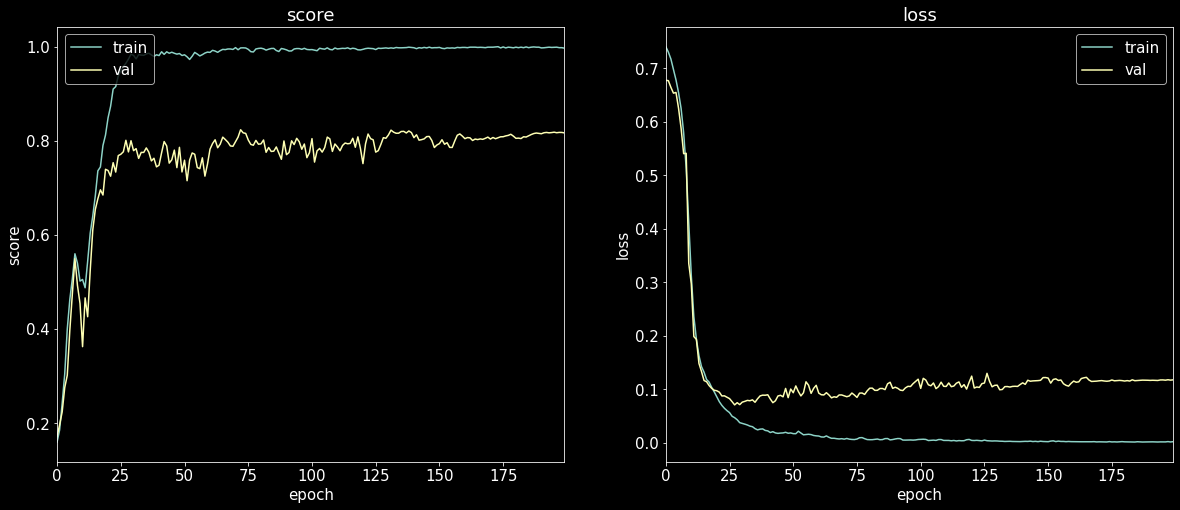


 -> Saving weights to models/efficientnet-b4_final_0.pt


-------------   Fold 2 / 5  -------------

    -> 973 training samples
    -> 243 validation samples
Loaded pretrained weights for efficientnet-b4
    -> 17668640 trainable parameters

Epoch 1/200 	 lr=1.0e-04 	 t=25s 	 loss=0.7403 	 score=0.1743 	 val_loss=0.6755 	 val_score=0.1486
Epoch 2/200 	 lr=2.0e-04 	 t=24s 	 loss=0.7330 	 score=0.1743 	 val_loss=0.6819 	 val_score=0.1611
Epoch 3/200 	 lr=3.0e-04 	 t=23s 	 loss=0.7184 	 score=0.2222 	 val_loss=0.6827 	 val_score=0.1895
Epoch 4/200 	 lr=4.0e-04 	 t=24s 	 loss=0.6994 	 score=0.3158 	 val_loss=0.6576 	 val_score=0.2372
Epoch 5/200 	 lr=5.0e-04 	 t=24s 	 loss=0.6782 	 score=0.3978 	 val_loss=0.6343 	 val_score=0.3274
Epoch 6/200 	 lr=6.0e-04 	 t=24s 	 loss=0.6552 	 score=0.4776 	 val_loss=0.6209 	 val_score=0.3402
Epoch 7/200 	 lr=7.0e-04 	 t=24s 	 loss=0.6219 	 score=0.5241 	 val_loss=0.5849 	 val_score=0.4242
Epoch 8/200 	 lr=8.0e-04 	 t=24s 	 loss=0.5757 	 score=0.5434 	

<Figure size 432x288 with 0 Axes>

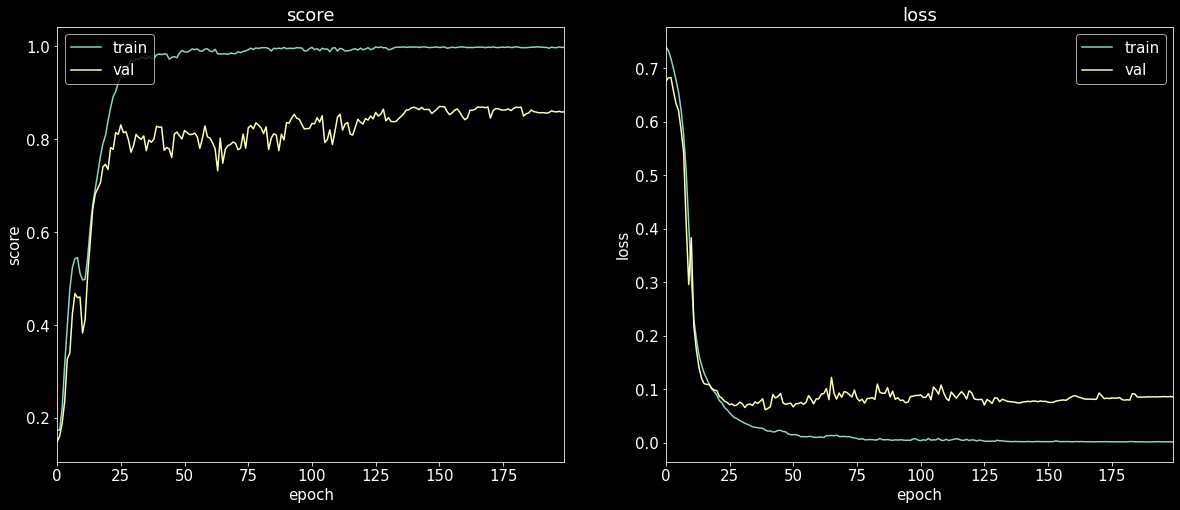


 -> Saving weights to models/efficientnet-b4_final_1.pt


-------------   Fold 3 / 5  -------------

    -> 973 training samples
    -> 243 validation samples
Loaded pretrained weights for efficientnet-b4
    -> 17668640 trainable parameters

Epoch 1/200 	 lr=1.0e-04 	 t=24s 	 loss=0.7436 	 score=0.1510 	 val_loss=0.6796 	 val_score=0.1539
Epoch 2/200 	 lr=2.0e-04 	 t=23s 	 loss=0.7330 	 score=0.1784 	 val_loss=0.6808 	 val_score=0.1536
Epoch 3/200 	 lr=3.0e-04 	 t=24s 	 loss=0.7165 	 score=0.2475 	 val_loss=0.6720 	 val_score=0.1740
Epoch 4/200 	 lr=4.0e-04 	 t=24s 	 loss=0.6962 	 score=0.3353 	 val_loss=0.6724 	 val_score=0.2435
Epoch 5/200 	 lr=5.0e-04 	 t=23s 	 loss=0.6770 	 score=0.4135 	 val_loss=0.6349 	 val_score=0.3347
Epoch 6/200 	 lr=6.0e-04 	 t=24s 	 loss=0.6541 	 score=0.4953 	 val_loss=0.6113 	 val_score=0.4131
Epoch 7/200 	 lr=7.0e-04 	 t=24s 	 loss=0.6202 	 score=0.5534 	 val_loss=0.5800 	 val_score=0.4838
Epoch 8/200 	 lr=8.0e-04 	 t=23s 	 loss=0.5701 	 score=0.6060 	

<Figure size 432x288 with 0 Axes>

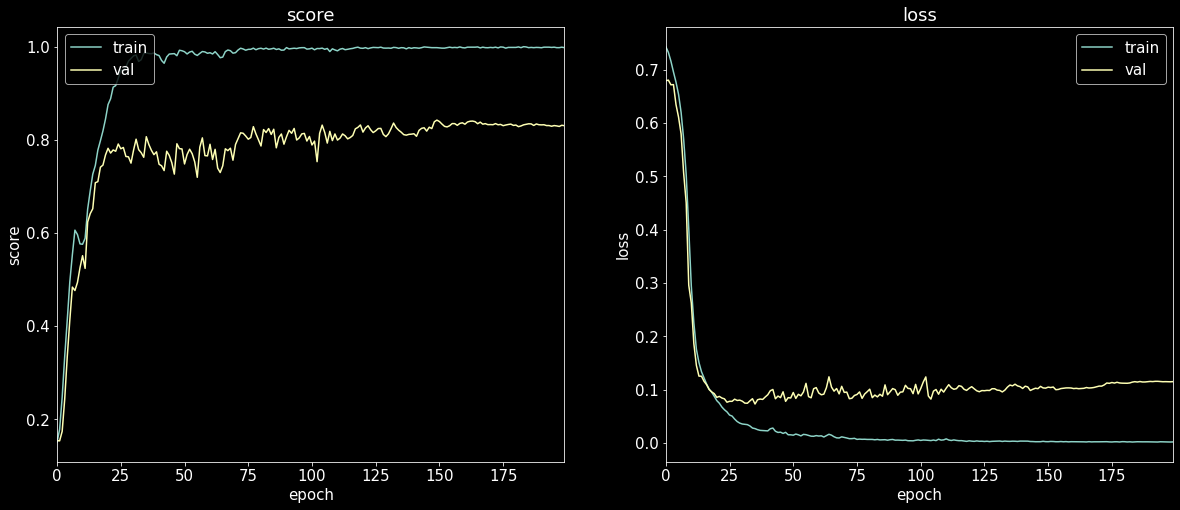


 -> Saving weights to models/efficientnet-b4_final_2.pt


-------------   Fold 4 / 5  -------------

    -> 973 training samples
    -> 243 validation samples
Loaded pretrained weights for efficientnet-b4
    -> 17668640 trainable parameters

Epoch 1/200 	 lr=1.0e-04 	 t=24s 	 loss=0.7419 	 score=0.1620 	 val_loss=0.6740 	 val_score=0.1618
Epoch 2/200 	 lr=2.0e-04 	 t=23s 	 loss=0.7328 	 score=0.2006 	 val_loss=0.6819 	 val_score=0.1896
Epoch 3/200 	 lr=3.0e-04 	 t=24s 	 loss=0.7175 	 score=0.2287 	 val_loss=0.6668 	 val_score=0.1969
Epoch 4/200 	 lr=4.0e-04 	 t=23s 	 loss=0.6972 	 score=0.2935 	 val_loss=0.6584 	 val_score=0.2035
Epoch 5/200 	 lr=5.0e-04 	 t=24s 	 loss=0.6802 	 score=0.3472 	 val_loss=0.6370 	 val_score=0.2636
Epoch 6/200 	 lr=6.0e-04 	 t=24s 	 loss=0.6580 	 score=0.4274 	 val_loss=0.6273 	 val_score=0.3361
Epoch 7/200 	 lr=7.0e-04 	 t=23s 	 loss=0.6301 	 score=0.4739 	 val_loss=0.6022 	 val_score=0.3762
Epoch 8/200 	 lr=8.0e-04 	 t=24s 	 loss=0.5846 	 score=0.4949 	

<Figure size 432x288 with 0 Axes>

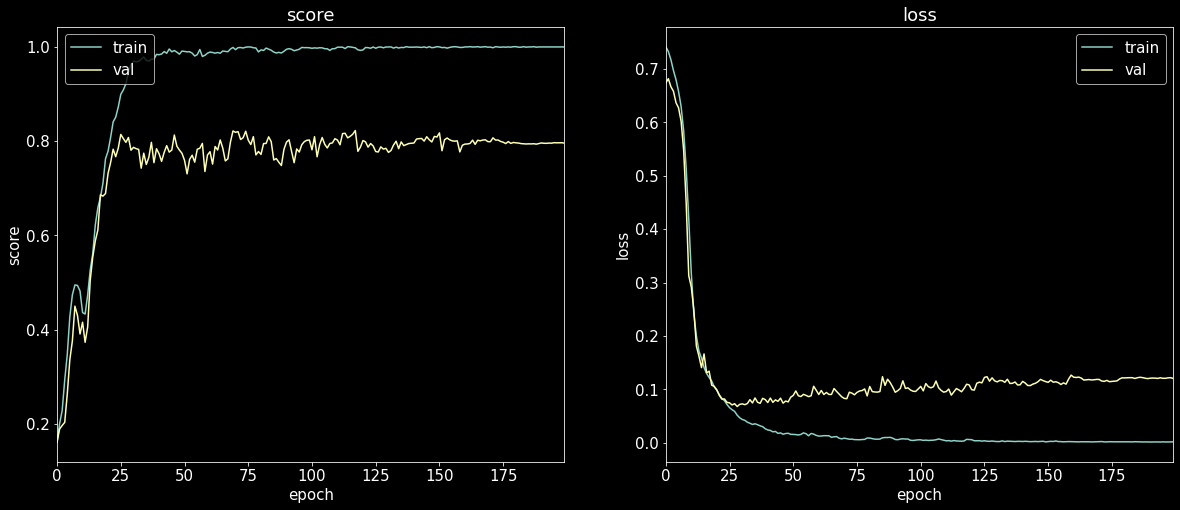


 -> Saving weights to models/efficientnet-b4_final_3.pt


-------------   Fold 5 / 5  -------------

    -> 973 training samples
    -> 243 validation samples
Loaded pretrained weights for efficientnet-b4
    -> 17668640 trainable parameters

Epoch 1/200 	 lr=1.0e-04 	 t=24s 	 loss=0.7420 	 score=0.1616 	 val_loss=0.6794 	 val_score=0.1539
Epoch 2/200 	 lr=2.0e-04 	 t=23s 	 loss=0.7333 	 score=0.2004 	 val_loss=0.6774 	 val_score=0.1502
Epoch 3/200 	 lr=3.0e-04 	 t=24s 	 loss=0.7158 	 score=0.2420 	 val_loss=0.6629 	 val_score=0.1787
Epoch 4/200 	 lr=4.0e-04 	 t=24s 	 loss=0.6987 	 score=0.3159 	 val_loss=0.6733 	 val_score=0.2285
Epoch 5/200 	 lr=5.0e-04 	 t=24s 	 loss=0.6757 	 score=0.4033 	 val_loss=0.6526 	 val_score=0.3127
Epoch 6/200 	 lr=6.0e-04 	 t=23s 	 loss=0.6520 	 score=0.4760 	 val_loss=0.6312 	 val_score=0.3746
Epoch 7/200 	 lr=7.0e-04 	 t=23s 	 loss=0.6207 	 score=0.5386 	 val_loss=0.6021 	 val_score=0.4394
Epoch 8/200 	 lr=8.0e-04 	 t=24s 	 loss=0.5797 	 score=0.5885 	

In [ ]:
# 学習
val_result, score = k_fold(config=Config, dfx=df_tp)

## 予測

In [ ]:
# 予測
result = test(config=Config, dfx=df_test)

In [ ]:
# csvを同じフォルダー内出力
today = str(datetime.date.today())
file_name = f"{today}_{Config.selected_model}_{Config.name}_{score:.4f}"
result.to_csv(f'submissions/{file_name}.csv', index=True) 